# Report: Collaboration and Competition Project

## Learning Algorithm

For the final project, an implementation of DDPG actor-critic learning algorithm has been used. Deep Deterministic Policy Gradient (DDPG) is an algorithm which concurrently learns a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy.

For the actor and critic networks, multi-layered perceptron networks have been used. The architecture has been inspired from OpenAI's implementation of DDPG in the Baselines library. Batch normalization layers have been used in order to help stabilize the learning. Xavier weight initialization is used for the linear layers of both networks.

In [ ]:
# Xavier init for linear layers
def linear_init(layer):
    classname = layer.__class__.__name__
    if classname.find('Linear') != -1:
        fan_in = layer.weight.data.size()[0]
        lim = 1./np.sqrt(fan_in)

        nn.init.uniform_(layer.weight.data, -lim, lim)


class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, seed=0):
        super(Actor, self).__init__()
        torch.manual_seed(seed)

        self.actor = nn.Sequential(
            nn.BatchNorm1d(state_size),
            nn.Linear(state_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, action_size),
            nn.Tanh()
        )
        self.apply(linear_init)

    def forward(self, state):
        return self.actor(state)


class Critic(nn.Module):
    def __init__(self, state_size, hidden_size, seed=0):
        super(Critic, self).__init__()
        torch.manual_seed(seed)

        self.first_layer = nn.Sequential(
            nn.BatchNorm1d(state_size),
            nn.Linear(state_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
        )

        self.critic = nn.Sequential(
            nn.Linear(hidden_size+2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.apply(linear_init)

    def forward(self, state, action):
        p_state = self.first_layer(state)
        a_state = torch.cat((p_state, action), dim=1)
        return self.critic(a_state)

The DDPG agent is defined below. Its hyperparameters are inspired from the stable baselines library. Because of the sparse rewards of self-play environments, we increase the batch size to 256, learning rate of the actor to .001 and hidden size of the networks to 516 for better learning.

In [ ]:
class Agent():
    def __init__(self, state_size, action_size, num_agents=2, hidden_size=512, batch_size=256, update_epochs=3, eps=1.0,
                 grad_clip=1.0, gamma=.99, lr=0.001, seed=0):
        random.seed(seed)
        self.batch_size = batch_size
        self.update_epochs = update_epochs
        self.eps = eps
        self.num_agents = num_agents
        self.grad_clip = grad_clip
        self.gamma = gamma
        self.lr = lr

        self.actor_local = Actor(state_size, action_size, hidden_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, hidden_size, seed).to(device)
        self.actor_target.load_state_dict(self.actor_local.state_dict())

        self.critic_local = Critic(state_size, hidden_size, seed).to(device)
        self.critic_target = Critic(state_size, hidden_size, seed).to(device)
        self.critic_target.load_state_dict(self.critic_local.state_dict())

        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.lr)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=self.lr, weight_decay=0)

        self.replay_buffer = ReplayBuffer()

        self.noise = OUNoise((self.num_agents, 2), seed)

    def act(self, state, add_noise=True):
        state = torch.tensor(state).to(device).float()
        actions = np.zeros((self.num_agents, 2))
        with torch.no_grad():
            self.actor_local.eval()
            for agent in range(self.num_agents):
                actions[agent, :] = self.actor_local(state[agent:agent+1, :]).cpu().data.numpy()
            self.actor_local.train()

        if add_noise:
            actions = actions + self.eps * self.noise.sample()

        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def step(self, state, action, reward, next_state, done):
        for agent in range(self.num_agents):
            self.replay_buffer.add(state[agent, :], action[agent, :], reward[agent], next_state[agent, :], done)

        if len(self.replay_buffer.buffer) > self.batch_size:
            for _ in range(self.update_epochs):
                experiences = self.replay_buffer.sample(self.batch_size)
                self.learn(experiences)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0-tau) * target_param.data)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Train critic to predict the current state's Q_value
        next_actions = self.actor_target(next_states)
        next_Q_targets = self.critic_target(next_states, next_actions)
        Q_targets = rewards + (self.gamma * next_Q_targets * (1-dones))

        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        # Update critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        if self.grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), self.grad_clip)
        self.critic_optimizer.step()

        # Train actor to predict the best action according to critic
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()

        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # soft-update the target networks
        self.soft_update(self.critic_local, self.critic_target, 0.002)
        self.soft_update(self.actor_local, self.actor_target, 0.002)

        if self.eps > 0:
            self.eps -= 0.000001
            self.noise.reset()
            if self.eps <= 0:
                self.eps = 0

The algorithm stores its trajectories in the replay buffer defined below. 

In [ ]:
class ReplayBuffer():
    def __init__(self, buffer_size=100000, seed=0):
        self.buffer = deque(maxlen=buffer_size)
        random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, k=batch_size)
        states      = torch.tensor([e[0] for e in experiences]).float().to(device)
        actions     = torch.tensor([e[1] for e in experiences]).float().to(device)
        rewards     = torch.tensor([e[2] for e in experiences]).float().unsqueeze(-1).to(device)
        next_states = torch.tensor([e[3] for e in experiences]).float().to(device)
        dones       = torch.tensor([e[4] for e in experiences]).float().to(device)
        return (states, actions, rewards, next_states, dones)

In the DDPG paper, the authors use Ornstein-Uhlenbeck Process to add noise to the action output (Uhlenbeck & Ornstein, 1930). The Ornstein-Uhlenbeck Process generates noise that is correlated with the previous noise, as to prevent the noise from canceling out or “freezing” the overall dynamics. Below is the implementation of the class.

In [1]:
class OUNoise:
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.01):
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

## Training
The algorithm managed to reach a score over 13 points in just 429 episodes. The following plot showcases the evolution of the reward (averaged over a 100 episode window) in time.

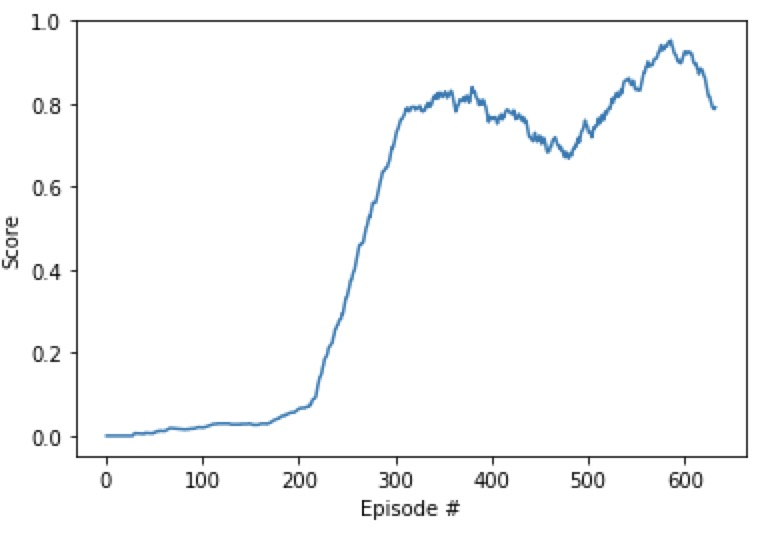

## Future work

DDPG has given good results, however MDDPG has been shown to be a better fit for multi-agent self play environments. The implementation of the algorithm can be a next step of this project.

## References

Uhlenbeck, G. E. and Ornstein, L.S. (1930) On the Theory of the Brownian Motion. Physical Review, 36, 823. 
http://dx.doi.org/10.1103/PhysRev.36.823